**Student:** Cheyenne Goh (24044342)

**Executes to the end without error:** Yes

**Code adapted from the following original sources:**
- https://github.com/ageron/handson-ml2/blob/master/18_reinforcement_learning.ipynb
- https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb
- https://github.com/keras-team/keras-io/blob/master/examples/rl/deep_q_network_breakout.py

# 0. Setup

In [ ]:
import sys

# Python 3.7 is required
assert sys.version_info >= (3, 7)

# Revert to Keras 2
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

from packaging import version
import tensorflow as tf

# Tensorflow >= 2.8 is required
assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.animation
import matplotlib.pyplot as plt

# Define default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Display Matplotlib animations using Javascript
plt.rc('animation', html='jshtml')

# Make sure there is a GPU
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    # Install the Gymnasium library
    %pip install -q -U gymnasium swig

    # Install the Atari environment
    %pip install -q -U gymnasium[atari]

# Supress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import numpy as np

import gymnasium as gym
import ale_py

from gymnasium.wrappers import TransformObservation
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import ResizeObservation
from gymnasium.wrappers import FrameStackObservation

from tqdm.auto import tqdm

%pip uninstall -y -q torch torchvision torchvision torchaudio
%pip install -q torch==2.5.0+cpu torchvision==0.20.0+cpu torchaudio==2.5.0+cpu \
    --index-url https://download.pytorch.org/whl/cpu
%pip install -q torchrl==0.6

import torch
from torchrl.data import ListStorage, PrioritizedReplayBuffer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 37.0 MB/s eta 0:00:00


# 1. Why Reinforcement Learning is the ML Paradigm of Choice for this Task

Reinforcement Learning (RL) is the machine learning (ML) paradigm of choice for the task of training an agent to play Atari 2600 games in the Gymnasium environment because games provide a excellent domain for the testing of RL algorithms. Games are challenging for RL agents and humans alike because they are made to involve interesting decisions. For this reason, reinforcement learning and games have had a long and sucessful history together [1].

Emulation frameworks such the Arcade Learning Environment (ALE) have made it accessible to implement AI agents for Atari 2600 roms [2]. This testbed provides agents with high dimensional visual input and a difficult set of tasks. Similar to how a human would interact with the game, agents learn directly from the video input, reward and terminal signals, and the set of possible actions. The use of a convolutional neural network (CNN) allows the agent to learn directly from gameplay frames [3].

RL considers tasks in which an agent interacts with an environment in a sequence of actions, observations, and rewards. In this task, the environment is the Atari emulator, the actions are the joystick controls, the observations are the video frames, and the rewards are the points scored in the game [3]. 

# 2. The Environment

In [ ]:
def plot_environment(env, figsize=(5, 4)):
    """Renders and plots an environment.

    # Arguments
        env: A gym.Env object.
        figsize: Width, height of figure in inches.

    # Returns
        Rendered frame as an image.
    """
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

## a. Atari Game Selected

The specific Atari game selected for this task is Breakout. 

In Breakout, the player controls a paddle to hit a ball towards a brick wall at the top of the screen. Every time the ball hits a brick, the brick disappears and points are scored. The goal is to destroy the brick wall. If the player misses the ball, it disappears off the screen and is lost. The game ends when all balls have been played [4].

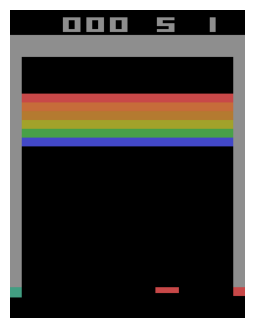

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

gym.register_envs(ale_py)

# Make a new Breakout environment
env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")

# Initialise the environment
obs, info = env.reset(seed=42)

# Display
img = plot_environment(env)

## b. Inputs Received from the Gym Environment

The Gymnasium environment provides input in each observation, which are video frames from gameplay. The `Box` observation space describes the format of the images, which are 210-by-160 images with 3 channels that range from 0 to 255 in value (8-bit RGB colour space).

In [ ]:
print(f'Observation Space: {env.observation_space}')

Observation Space: Box(0, 255, (210, 160, 3), uint8)


The agent also receives feedback from the environment in the form of rewards. In Breakout, the rewards are the points scored by destroying bricks in the wall. The scores awarded differ depending on the colour of the brick [2]. Red or orange bricks score 7 points, yellow or green bricks score 4 points, and aqua or blue bricks score 1 point [4].

## c. Control Settings for the Joystick

The number of possible control inputs are described by the action space. The 4 actions correspond to the different joystick inputs. The value `0` means `NOOP`, `1` means `FIRE`, `3` means `RIGHT`, and `4` means `LEFT` [2].

In [ ]:
print(f'Action Space: {env.action_space}')
print(f'Action Meanings: {env.unwrapped.get_action_meanings()}')

Action Space: Discrete(4)
Action Meanings: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


# 3. Vanilla DQN Implementation

In [ ]:
class CropObservation(TransformObservation):
    """Environment wrapper that applies a cropping transformation to the
    observation.
    """

    def __init__(self, env, p1, p2):
        """Initialises the CropObservation object.

        # Arguments
            env: A gym.Env object.
            p1: Coordinates of top-left corner of cropped area as a tuple.
            p2: Coordinates of bottom-right corner of cropped area as a tuple.

        # Returns
            None.
        """
        self.shape = (p2[1] - p1[1], p2[0] - p1[0])

        new_observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=self.shape,
            dtype=np.uint8,
        )

        gym.utils.RecordConstructorArgs.__init__(self, shape=self.shape)
        TransformObservation.__init__(
            self,
            env=env,
            func=lambda obs: obs[p1[1]:p2[1], p1[0]:p2[0]],
            observation_space=new_observation_space,
        )


class AtariPreprocessingWithAutoFire(AtariPreprocessing):
    """Environment wrapper that applies standard Atari preprocessing with
    automatic FIRE action at the start of each life.
    """

    def step(self, action):
        """Run one timestep of the environment’s dynamics using the agent
        actions with FIRE action after life lost.

        # Arguments
            action: Action provided by the agent to update the environment
                state.

        # Returns
            Tuple of observation, reward, truncated, info, and done.
        """
        lives_before_action = self.ale.lives()
        obs, reward, done, truncated, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:

            # FIRE to start after life lost
            super().step(1)

        return obs, reward, done, truncated, info


    def reset(self, **kwargs):
        """Resets the environment to an initial internal state with FIRE action
        to start.

        # Arguments
            seed: Seed that is used to initialize the environment’s PRNG
                (np_random) and the read-only attribute np_random_seed.
            options: Additional information to specify how the environment is
                reset.

        # Returns
            Tuple of initial observation and info.
        """
        obs, info = super().reset(**kwargs)

        # FIRE to start
        super().step(1)

        return obs, info


class ReplayBuffer:
    """Implementation of a basic circular replay buffer.
    """

    def __init__(self, max_size):
        """Initialises the ReplayBuffer object.

        # Arguments
            max_size: Maximum size of replay buffer.

        # Returns
            None.
        """
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0


    def append(self, obj):
        """Adds an object to the replay buffer.

        # Arguments
            obj: Experience object to be added to the replay buffer

        # Returns
            None.
        """
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size


    def sample(self, batch_size):
        """Randomly samples a batch of experiences from the replay buffer.

        # Arguments
            batch_size: Size of batch as an integer.

        # Returns
            A list of NumPy arrays containing the sampled batch of experiences.
        """
        indices = np.random.randint(self.size, size=batch_size)
        batch = self.buffer[indices]
        return [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(6)
        ]


def apply_preprocessing(env):
    """Applies the AtariPreprocessingWithAutoFire, CropObservation,
    ResizeObservation, and FrameStackObservation preprocessing wrappers to the
    environment.

    # Arguments
        env: A gym.Env object.

    # Returns
        The environment with preprocessing wrappers applied.
    """
    # Noop reset, frame skipping, max-pooling, greyscale observation, auto-fire,
    # and terminal on life loss
    env = AtariPreprocessingWithAutoFire(env, screen_size=(160, 210),
                                         terminal_on_life_loss=True)

    # Crop observations
    env = CropObservation(env, p1=(8, 32), p2=(152, 196))

    # Resize observations
    env = ResizeObservation(env, shape=(84, 84))

    # Merge consecutive images to form each state
    env = FrameStackObservation(env, stack_size=4)

    return env


def plot_observation(obs):
    """Plots observation consisting of four stacked frames as an image with red,
    green, blue, and pink channels.

    # Arguments
        obs: The observation as a NumPy array.

    # Returns
        None.
    """
    obs = np.moveaxis(obs, 0, -1)
    obs = obs.astype(np.float32)

    img = obs[..., :3]

    # Computes delta between current frame and mean of other frames
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1),
                                     0.)

    # Adds delta to red and blue channels to get a pink color for current frame
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta

    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")


def epsilon_greedy_policy(state, epsilon=0):
    """Applies the epsilon-greedy algorithm to balance exploration and
    exploitation.

    # Arguments
        state: The observation as a NumPy array.
        epsilon: Proability of taking random action as a float.

    # Returns
        An action that is either random or optimal according to the DQN.
    """
    if np.random.rand() < epsilon:
        # Random action
        return np.random.randint(n_outputs)
    else:
        # Optimal action according to the DQN
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()


def play_one_step(env, state, epsilon):
    """Takes an action according to epsilon-greedy policy and saves experience
    in the replay buffer.

    # Arguments
        env: A gym.Env object.
        state: The observation as a NumPy array.
        epsilon: Proability of taking random action as a float.

    # Returns
        A tuple of next state, reward, done, truncated, and info.
    """
    # Use epsilon-greedy for exploration
    action = epsilon_greedy_policy(state, epsilon)

    # Apply the sampled action in our environment
    next_state, reward, done, truncated, info = env.step(action)

    # Save actions and states in replay buffer
    replay_buffer.append((state, action, reward, next_state, done, truncated))

    return next_state, reward, done, truncated, info


def training_step_vanilla_dqn(batch_size):
    """Executes a training step for vanilla DQN.

    # Arguments
        batch_size: Size of batch as an integer.

    # Returns
        None.
    """
    # Sample from replay buffer
    experiences = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    next_Q_values = target.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)

    # Episode is not done or truncated
    runs = 1.0 - (dones | truncateds)

    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    # Create a mask so we only calculate loss on the updated Q-values
    mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        all_Q_values = model(states)

        # Apply the masks to the Q-values to get the Q-value for action taken
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)

        # Calculate loss between new Q-value and old Q-value
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
batch_size = 32
discount_factor = 0.99

max_episodes = 5000
max_steps_per_episode = 27000
max_memory_length = 10000

update_after_actions = 4
update_target_network = 1000

## a. Capture and Pre-Processing of the Data

The data is captured and pre-processed using a number of Gymnasium wrappers, which are used to modify an existing environment without needing to alter the underlying code directly.

First, the `AtariPreprocessingWithAutoFire` wrapper is applied. This class inherits from `AtariPreprocessing`, which handles some of the common preprocessing techniques used for Atari environments. It takes care of noop reset, which obtains the initial state by taking a random number of no-ops on reset. It also applies frame skipping to skip frames between steps and max-pooling to pool over the most recent two observations from the frame skips. It converts the observation to greyscale and sends a termination signal when a life is lost as well. `AtariPreprocessingWithAutoFire` adds to the existing functionality by implementing an automatic FIRE action at the start of each life.

Next, the `CropObservation` wrapper is applied. This wrapper crops the original observation to the main gameplay area. Since there is no existing Gymnasium wrapper for this functionality, I designed one by inheriting from the general-purpose `TransformObservation` environment wrapper class. 

Then, the `ResizeObservation` wrapper is applied. This is used to resize the image to 84-by-84 dimensions.

Finally, the `FrameStackObservation` wrapper is applied. The purpose of this wrapper is to merge consecutive images as separate channels to form each state. By combining several time steps, each observation can convey the notion of movement to the agent.

The sequential model itself performs some further preprocessing by reshaping the input to be channel last and scaling the pixel values to the range [0, 1).

In [ ]:
# Apply preprocessing
env = apply_preprocessing(env)

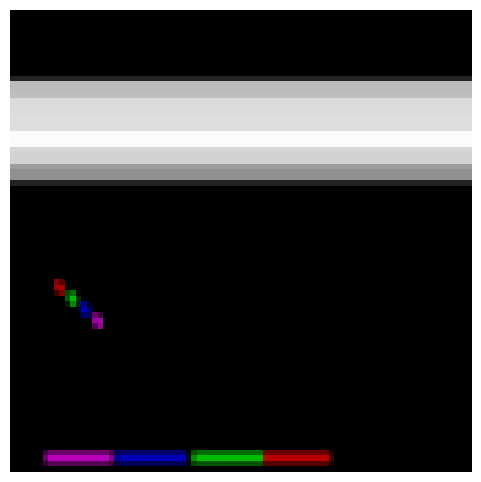

In [ ]:
# Initialise the environment
obs, info = env.reset(seed=42)
for _ in range(4):

    # LEFT
    time_step = env.step(3)

# Display preprocessed breakout plot
plt.figure(figsize=(6, 6))
plot_observation(time_step[0])
plt.show()

## b. Network Structure

The network structure used is a convolution neural network (CNN) with three 2D convolutional layers and two fully connected layers, intended to replicate the model described in the 2015 DeepMind paper [5].

The first convolutional layer consists of an 8-by-8 kernel with 32 filters and stride 4. The second convolutional layer consists of a 4-by-4 kernel with 64 filters and stride 2. The third convolutional layer consists of a 3-by-3 kernel with 64 filters and stride 1. All three convolutional layers use the ReLU activation function.

The first fully-connected layer has 512 units and uses the ReLU activation function. The second fully-connected layer has four output units which correspond to each of the valid controls in the action space. This output layer uses a linear activation function.

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4,
                                        rho=0.95,
                                        momentum=0.0,
                                        epsilon=0.00001,
                                        centered=True)

loss_fn = tf.keras.losses.Huber()

In [ ]:
# Ensures reproducibility on the CPU
tf.random.set_seed(42)

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    # Preprocessing
    tf.keras.layers.Permute((2, 3, 1), input_shape=input_shape),
    tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.),

    # Convolutional layers
    tf.keras.layers.Conv2D(32, (8, 8), 4, activation="relu"),
    tf.keras.layers.Conv2D(64, (4, 4), 2, activation="relu"),
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation="relu"),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(n_outputs, activation="linear")
])

# Clone the model's architecture
target = tf.keras.models.clone_model(model)

# Copy the weights
target.set_weights(model.get_weights())

# For reproducibility
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

## c. Q-Learning Update Applied to the Weights

The Q-Learning algorithm is an off-policy algorithm that works by watching an agent play and slowly improving its estimates of the Q-Values. When the approximated Q-values are accurate, the optimal policy will be choosing the action with the highest Q-Value. The algorithm can be expressed as,

$$ Q(s, a) \underset{\alpha}{\rightarrow} r + \gamma \cdot \max_{a'} Q(s', a') \text{,} $$

where $s$ is the state, $a$ is the action, and $\gamma$ is the discount factor. For a given state-action pair $(s, a)$, the algorithm monitors the running average of rewards $r$ the agent gets from leaving state $s$ with action $a$. This value is added to the sum of the discounted future rewards expected. This value is estimated from the maximum of the Q-Value estimates for the next state $s'$, since the target policy is assumed to behave optimally from that point onwards [6].

To apply this concept in practice, we start each training step by sampling a batch of experiences and using a neural network to predict the Q-Value for each possible action in each experience's next state, retaining the maximum Q-Value. Next, the target Q-value is computed for each experience. Then, we mask out the state-action pair for the action selected by the agent. Afterwards, the loss is computed between the target and predicted Q-Values. Finally, Gradient Descent is performed to minimise loss in the model's weights [6].

This implementation uses fixed Q-Value targets, which uses a cloned target model to predict the Q-Values of the next states. At regular intervals, the weights of the online model are copied to the target model. Using fixed Q-Value targets improves stability, since it dampens the feedback loop that can make the network unstable [6].

In [ ]:
replay_buffer = ReplayBuffer(max_memory_length)

rewards = []
moving_average_rewards = []
steps_taken = []

epsilon = 1.0
frame_count = 0
best_score = 0

episode_iterator = tqdm(range(max_episodes))
for episode in episode_iterator:
    obs, info = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)

        # Decay probability of taking random action
        epsilon -= (1 - 0.1) / 100000
        epsilon = max(epsilon, 0.1)

        # Run training step every 4 frames
        if (frame_count % update_after_actions == 0
            and replay_buffer.size > batch_size):
            training_step_vanilla_dqn(batch_size)

        # Update target network every 1000 frames
        if frame_count % update_target_network == 0:
            target.set_weights(model.get_weights())

        episode_reward += reward
        frame_count += 1

        if done or truncated:
            break

    # Record rewards
    rewards.append(episode_reward)

    # Record moving average reward
    moving_average_rewards.append(np.mean(rewards[-100:]))

    # Record steps taken
    steps_taken.append(step)

    tqdm.write(f"\repisode: {episode + 1}, steps: {step + 1}, " \
               f"frame count: {frame_count}, epsilon: {epsilon:.3f}, " \
               f"episode reward: {episode_reward}, " \
               f"moving average reward: {moving_average_rewards[-1]:.3f}",
               end='')

    # Keeps track of the best model weights so far
    if episode_reward >= best_score:
        best_weights = model.get_weights()
        best_score = episode_reward

# Restores the best model weights
model.set_weights(best_weights)

  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 5000, steps: 24, frame count: 178980, epsilon: 0.100, episode reward: 0.0, moving average reward: 0.320

# 4. Results and Evaluation for Vanilla DQN

In [ ]:
def update_scene(num, frames, patch):
    """Updates the scene at each frame.

    # Arguments
        num: Next value in frames.
        frames: Rendered frames as NumPy arrays.
        patch: An matplotlib.image.AxesImage object.

    # Returns
        Patch with frames set as data.
    """
    patch.set_data(frames[num])
    return patch,


def plot_animation(frames, repeat=False, interval=40):
    """Plots frames as matplotlib animations.

    # Arguments
        frames: Rendered frames as NumPy arrays.
        repeat: Whether the animation repeats when the sequence of frames is
            completed.
        interval: Delay between frames in milliseconds.

    # Returns
        A matplotlib.animation.FuncAnimation object.
    """
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


def show_one_episode(policy, n_max_steps=10000, seed=42):
    """Displays an animation of an episode of Breakout gameplay.

    # Arguments
        policy: Policy function to use in episode.
        n_max_steps: Maximum number of steps to take as an integer.
        seed: Seed for reproducibility as an integer.

    # Returns
        A matplotlib.animation.FuncAnimation object.
    """
    frames = []
    env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")
    env = apply_preprocessing(env)
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

## a. Plots

The rewards per episode plot shows the rewards attained over the course of 5000 episodes. While this plot is very noisy, it gives an indication of the distribution of rewards, as well as the maximum and minimum values at different episodes. 

We can see from the plot that the maximum reward acheived by the agent is 5, both of which occured between the episodes 3000 and 4000. However, the bulk of the episodes yielded no reward throughout this process.

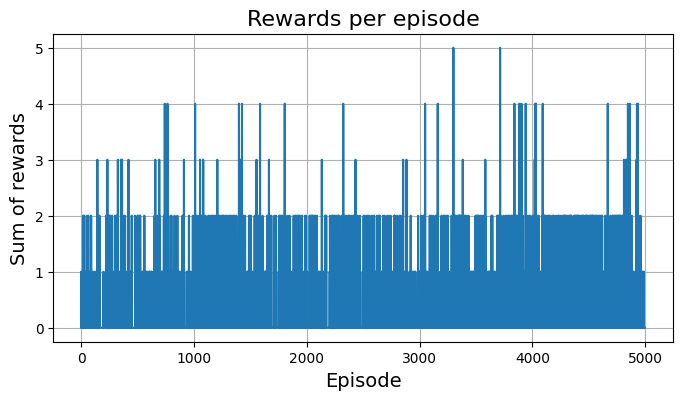

In [ ]:
# Plot rewards per episode
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Rewards per episode", fontsize=16)
plt.grid(True)
plt.show()

By taking the average of the previous 100 episodes at any given point, we obtain a moving average graph, which reduces the noise and allows us to see the underlying trend.

From this moving average graph,  we can see a gradual upwards trajectory, despite not reaching any impressive value. The peak of the graph can be found towards the end of training, between episodes 4000 and 5000. 

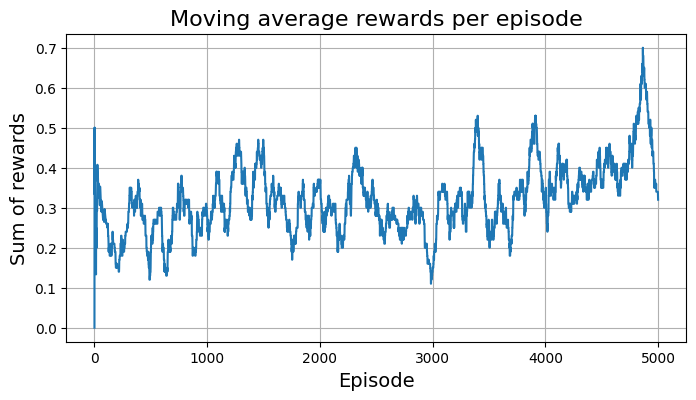

In [ ]:
# Plot moving average rewards per episode
plt.figure(figsize=(8, 4))
plt.plot(moving_average_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Moving average rewards per episode", fontsize=16)
plt.grid(True)
plt.show()

The steps taken per episode is shown in the following plot, which is the number of elapsed frames before the run is terminated. For the most part, this plot follows the general outline of the rewards per episode fairly closely. This is due to the fact that the ball usually only hits one brick at a time, at least in the earlier phases of the game.

We can see in this plot that there is a lot of variation in steps taken at the beginning of training, but less towards the end.

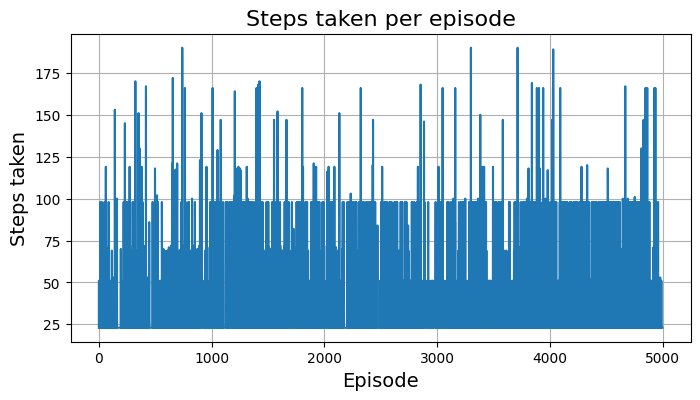

In [ ]:
# Plot steps taken per episode
plt.figure(figsize=(8, 4))
plt.plot(steps_taken)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Steps taken", fontsize=14)
plt.title("Steps taken per episode", fontsize=16)
plt.grid(True)
plt.show()

## b. How Does One Evaluate the Performance of the RL Agent?

The performance of an RL agent can be evaluated by measuring the reward and learning curves over time, as was done in the previous section.

The performance can also be compared to existing benchmarks. DeepMind reports benchmarks of 1.7 for random play, 31.8 for professional human games tester, and 401.2 for DQN agents [5]. Since all 5 lives were used in their evaluations, we can reasonably divide these values by 5 to estimate a rewards per life metric. This is relevant in our case since each episode terminates on life loss. The calculation gives us benchmark rewards of 0.34 for random play, 6.36 for human, and 80.2 for DQN per life.

We can also render the video frames of an episode, which gives a visual indication of how the model is performing. This is shown below for our vanilla DQN agent.

It is clear from the animation that the model still behaves erratically and in such a way that does not seem correct to a human viewer.

In [ ]:
# Display an animation of one episode
show_one_episode(epsilon_greedy_policy)

## c. Is the Agent Learning?

While these results are far from spectacular, they do suggest some level of learning from the agent. When compared to random play, which yields an average of 0.34 rewards per play, the moving average does eventually exceed this value, although not by much. However, this agent is very far from the human and DQN benchmarks. 

The plots also suggest slight improvements in consistency when attaining rewards towards the end of the training cycle. Yet, it is unclear if running the model for more episodes would lead to any improvements in performance. Considering that the 5000 episodes came out to 178,980 frames, further improvements are certainly possible before reaching the 10,000,000 frames used in the DeepMind paper [5].

# 5. Double DQN Implementation

In [ ]:
def training_step_double_dqn(batch_size):
    """Executes a training step for double DQN.

    # Arguments
        batch_size: Size of batch as an integer.

    # Returns
        None.
    """
    # Sample from replay buffer
    experiences = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    next_Q_values = model.predict(next_states, verbose=0)
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)

    # Episode is not done or truncated
    runs = 1.0 - (dones | truncateds)

    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    # Create a mask so we only calculate loss on the updated Q-values
    mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        all_Q_values = model(states)

        # Apply the masks to the Q-values to get the Q-value for action taken
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)

        # Calculate loss between new Q-value and old Q-value
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## a. Problem Being Addressed

In a 2015 paper, DeepMind published a paper on Double DQN, a variant of the DQN algorithm that addresses the issue of overestimating action values in some conditions. These substantial overestimations are common and harm performance, impacting the stability and reliability of the learning algorithm [7].

The problem stems from the target model's tendency to overestimate Q-Values. Ideally, when all actions are equally good, the Q-Values estimated by the target model should all be the same. However, since these values are approximated, there's some random variation in the values. Because the target always selects the largest Q-Value, this value is likely greater than mean Q-value, leading to an overestimation. The proposed changes aimed to increase performance and somewhat stabilise training [6].

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4,
                                        rho=0.95,
                                        momentum=0.0,
                                        epsilon=0.00001,
                                        centered=True)

loss_fn = tf.keras.losses.Huber()

In [ ]:
# Ensures reproducibility on the CPU
tf.random.set_seed(42)

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    # Preprocessing
    tf.keras.layers.Permute((2, 3, 1), input_shape=input_shape),
    tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.),

    # Convolutional layers
    tf.keras.layers.Conv2D(32, (8, 8), 4, activation="relu"),
    tf.keras.layers.Conv2D(64, (4, 4), 2, activation="relu"),
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation="relu"),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(n_outputs, activation="linear")
])

# Clone the model's architecture
target = tf.keras.models.clone_model(model)

# Copy the weights
target.set_weights(model.get_weights())

# For reproducibility
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
replay_buffer = ReplayBuffer(max_memory_length)

rewards = []
moving_average_rewards = []
steps_taken = []

epsilon = 1.0
frame_count = 0
best_score = 0

episode_iterator = tqdm(range(max_episodes))
for episode in episode_iterator:
    obs, info = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)

        # Decay probability of taking random action
        epsilon -= (1 - 0.1) / 100000
        epsilon = max(epsilon, 0.1)

        # Run training step every 4 frames
        if (frame_count % update_after_actions == 0
            and replay_buffer.size > batch_size):
            training_step_double_dqn(batch_size)

        # Update target network every 1000 frames
        if frame_count % update_target_network == 0:
            target.set_weights(model.get_weights())

        episode_reward += reward
        frame_count += 1

        if done or truncated:
            break

    frame_count += step

    # Record rewards
    rewards.append(episode_reward)

    # Record moving average reward
    moving_average_rewards.append(np.mean(rewards[-100:]))

    # Record steps taken
    steps_taken.append(step)

    tqdm.write(f"\repisode: {episode + 1}, steps: {step + 1}, " \
               f"frame count: {frame_count}, epsilon: {epsilon:.3f}, " \
               f"episode reward: {episode_reward}, " \
               f"moving average reward: {moving_average_rewards[-1]:.3f}",
               end='')

    # Keeps track of the best model weights so far
    if episode_reward >= best_score:
        best_weights = model.get_weights()
        best_score = episode_reward

# Restores the best model weights
model.set_weights(best_weights)

  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 5000, steps: 24, frame count: 348440, epsilon: 0.100, episode reward: 0.0, moving average reward: 0.230

## b. Theoretical Solution

The theoretical solution to the problem of overestimation proposed by the Double DQN is to decompose the max operation in the target into action selection and action evalaution. The idea is to evaluate the greedy policy according to the online network, but use the target network to estimate its value [7].

The update is done in a similar manner to DQN, but the vanilla DQN target,

$$ Y^{\text{DQN}}_t \equiv R_{t + 1} + \gamma \max_a Q(S_{t + 1}, a; \bf{\theta}^-_t) \text{,} $$

is replaced with the Double DQN target,

$$ Y^{\text{DoubleDQN}}_t \equiv R_{t + 1} + \gamma Q(S_{t + 1}, \argmax_a Q(S_{t + 1}, a; \bf{\theta}_t), \bf{\theta}^-_t) \text{.} $$

The selection of the action is still due to the online weights but the second set of weights is used to fairly evaluate the value of the policy. This minimal change helps reduce the issue of overoptimism by decoupling selection from evaluation, without the need to introduce additional networks or other computation overhead. This has been shown to mitigate severe outcomes caused by the inherent estimation errors, leading to more stable and reliable learning [7].

# 6. Results and Evaluation for Double DQN

The rewards per episode plot for this agent exhibits erratic behaviour in general. There are some higher rewards in the middle of the run but it drops off dramatically after episode 4000.

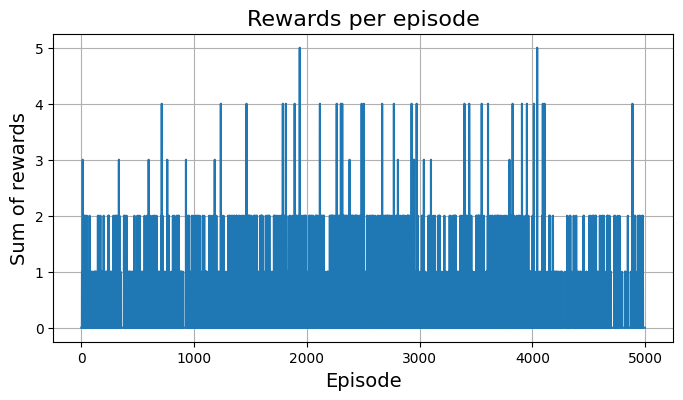

In [ ]:
# Plot rewards per episode
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Rewards per episode", fontsize=16)
plt.grid(True)
plt.show()

It is clear from the moving average rewards per episode that the agent has some gradual improvement in the earlier half of the run but drops off steeply to show worse than random performance by the end. This is indicative of catastrophic forgetting, since the model initially shows some progress then proceeds to suddenly perform very poorly.

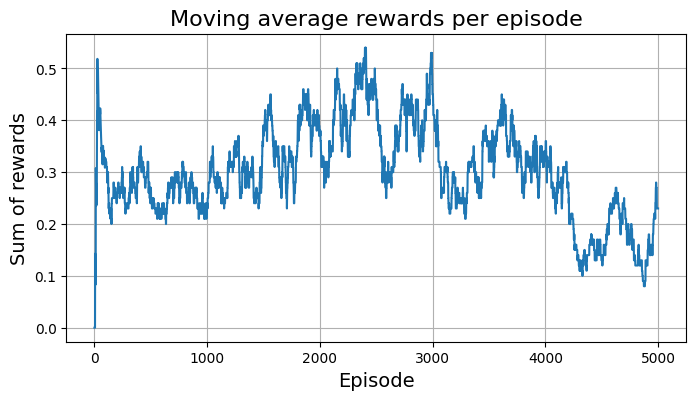

In [ ]:
# Plot moving average rewards per episode
plt.figure(figsize=(8, 4))
plt.plot(moving_average_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Moving average rewards per episode", fontsize=16)
plt.grid(True)
plt.show()

Similar to the previous plots, the plot for steps taken per episode demonstrate a drastic drop in performance in the latter third of the process.

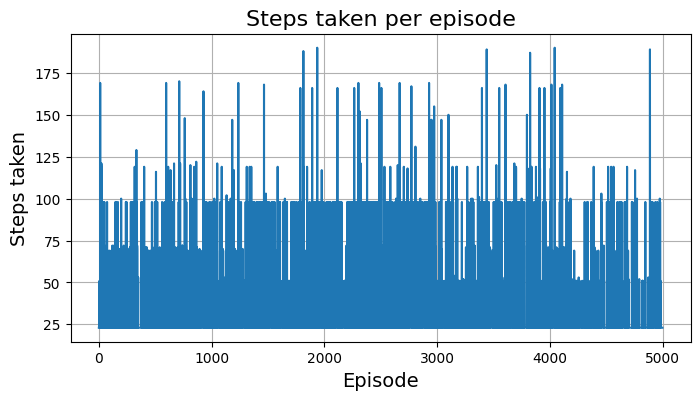

In [ ]:
# Plot steps taken per episode
plt.figure(figsize=(8, 4))
plt.plot(steps_taken)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Steps taken", fontsize=14)
plt.title("Steps taken per episode", fontsize=16)
plt.grid(True)
plt.show()

Upon viewing an animation of one episode, it is clear that the model is not quite on the right track. The behaviour does not seem like a very reasonable technique as a human observer.

In [ ]:
# Display an animation of one episode
show_one_episode(epsilon_greedy_policy)

Overall the result of this agent are very poor. The final moving average reward was 0.230, which is less than random play (0.34), and obviously far worse than the other benchmark. 

However, there was some indication of the model learning prior to the likely catastrophic forgetting event. From episodes 2000 to 3000, the model was showing some slight improvement over random play, which was lost in consequent episodes. Since the frame count only reached 348,440 at the end of 5000 episodes, further improvement is still possible over a longer time period. 

# 7. Comparisons of DQN vs Double DQN

In literature, Double DQN agents have been shown to produce better performance than DQN on several games. However, in the case of Breakout, the vanilla DQN acheived a slightly better score of 401.20 when compared to 375.00 of the Double DQN [7]. 

Using the identical hyperparameter setups, both the DQN and Double DQN agents shown acheived similarly poor overall results in their respective runs. The DQN and Double DQN models ended their runs at rewards of 0.320 and 0.230 respectively. The fact that our DQN agent slightly outperforms its Double DQN counterpart aligns with the aforementioned paper, although the performance attained was nowhere close. Both agents failed to break free from the neighbourhood of the random play (0.34), despite showing some potential indications of learning during the training process. Furthermore, they both acheived a maximum reward of 5 with a minimum of 0.

Comparing both plots, the DQN managed to produce a more consistent learning curve that increased steadily. On the other hand, the Double DQN grows at a sharper rate before sharply decreasing. Both moving average plots appeared to exhibit a similar fine-grain osciallation.

Some possible reasons for the overall poor performance include the memory buffer being too small or running the algorithm for too short of a duration. Another key oversight is that there was little hyperparameter tuning done specifically for each of these setups. The intention was to demonstrate a fair comparison between these two networks, as well as the improved DQN model, which is shown in the next section. However, since a number of relevant hyperparameters were tuned with the improved agent in mind, it is very likely that the hyperparameters shown are not particularly suitable for these agents, leading to these suboptimal results.

While this is surely unfortunate, we will see by the end of the notebook that with a few simple changes, the Double DQN model can achieve clearly evident learning that is fairly comparable to that of a human player.

# 8. Added Value Implemented and Evaluated

## a. Independently Researched Concepts

I independently investigated several concepts in terms of hyperparameter tuning to try and improve my results as much as possible. A few of the concepts were implemented across the notebook, while other modifications are implemented and evaluated within this section on a Double DQN agent.

During the overall development of this notebook, I experimented with different values for batch size, maximum buffer memory length, update frequencies, and the annealing of $\epsilon$ values.

The batch size of an RL algorithm indicates the number of data samples captured in a training run. Small batch sizes increase the time it takes to train the model and can cause dramatic vibrations. However, fewer calculations are needed. On the other hand, running large batch sizes cause different batches to share similar gradient direction, leading to covergence in local minima [8]. 

For maximum memory length, larger buffer sizes tend to improve stability since it prevents catastrophic forgetting [6]. While this holds true, there is a slight tradeoff in that performance consistently improves with increase capacity and generally improves with reducing the age of the oldest policy [9]. This suggests that there are disadvanges to having large buffers that hold onto older, off-policy data. Another issue is memory consumption, since storing and accessing large amounts of data may be slow or impossible.

In practice, I found that batch size and maximum memory length were challenging to tune because they relied heavily on the amount of memory available on a given device. In several instances, I came across my runtime having been terminated due to an out-of-memory (OOM) error after a few hours of execution. In order to avoid these time-consuming incidents, I chose to err on the side of caution and settled on small values of `batch_size = 32`, which is the same value used in the DeepMind paper, and `max_memory_length = 10000`, which is two orders of magnitude smaller than that in the paper [3].

Regarding update frequencies, my initial implementation performed a training step every episode and updated the target model every 50 episodes, which is suitable for simpler tasks such as CartPole but yielded poor results on Atari. After reviewing literature from DeepMind, I implemented their hyperparameters of performing a training step every 4 frames and updating the target model every 10,000 frames. However, I did not achieve any notable improvements. Upon reducing the target update model frequency to 1000, I was able to see some improvements in the agents. I believe that this reduction was necessary to account for having selected a much smaller buffer size than in the paper [3].

In terms of the $\epsilon$ value for the $\epsilon$-greedy exploration, I initially began with linearly annealing this value over 1,000,000 frames from 1 to 0.1, as was done in the DeepMind paper [5]. However, I found that I achieved my best results by reducing this value by a factor of 10. This made a difference significant difference because I was planning on running the algorithm for a far shorter duration, so with a large $\epsilon$ value, the agent would not be able to transition from the exploration to exploitation phase within the time frame.

The two additional hyperparameters I explored were improvements in the choices of optimiser and initialiser.

The previous two agents use the RMSProp algorithm as an optimizer, as described in the original DeepMind paper [3]. However, the Adam optimizer, which is used in DeepMind's integrated RL agent Rainbow, is less sensitive to the choice of learning rate [10]. Adam is an improved first-order gradient optimizer that, unlike RMSProp, normalizes for first and second gradient moments [9]. It has also been found to improve training times [11].

For initialisation, the earlier agents in the notebook use the default kernel initializer method in Keras, which is the Glorot (Xavier) initializer. However, its derivation is based on the assumption that activations are linear, which is invalid for ReLU, which is the activation function used. On the other hand, the He optimiser is much more appropriate because it accounts for the non-linear case in its derivation [12]. In Keras, He initialisation is implemented using the `VarianceScaling` initialiser.

In [ ]:
# Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-4, clipnorm=1.0)

# He initialisation
initializer = tf.keras.initializers.VarianceScaling

loss_fn = tf.keras.losses.Huber()

In [ ]:
# Ensures reproducibility on the CPU
tf.random.set_seed(42)

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    # Preprocessing
    tf.keras.layers.Permute((2, 3, 1), input_shape=input_shape),
    tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.),

    # Convolutional layers
    tf.keras.layers.Conv2D(32, (8, 8), 4, activation="relu",
                           kernel_initializer=initializer(scale=2)),
    tf.keras.layers.Conv2D(64, (4, 4), 2, activation="relu",
                           kernel_initializer=initializer(scale=2)),
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation="relu",
                           kernel_initializer=initializer(scale=2)),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu",
                          kernel_initializer=initializer(scale=2)),
    tf.keras.layers.Dense(n_outputs, activation="linear")
])

# Clone the model's architecture
target = tf.keras.models.clone_model(model)

# Copy the weights
target.set_weights(model.get_weights())

# For reproducibility
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

## b. Prioritised Experience Replay

Prioritised experience replay (PER) is a framework developed by DeepMind to prioritize experiences sampled from the replay buffer, rather than using uniformly sampling as in the previous iteration of experience replay. Replaying important transitions more frequently allows the RL agent to learn more efficiently, since transitions differ in terms of how suprising, redundant, or task-relevant they are [13]. 

The idea in PER is to replay transitions with high expected learning progress more frequently. This can be measured by the magnitude of their temporal-difference (TD) error,

$$ \delta_j = R_j + \gamma Q_{\text{target}} (S_j, {\argmax}_a Q(S_j, a)) - Q(S_{j - 1}, A_{j - 1}) \text{.} $$

The TD-error $\delta$ is indicative of how surpising or unexpected a transition is. This acts as a reasonable proxy in determining how much an agent can learn from a particular transition. Since new transitions arrive without a known TD-error, they are assigned maximum priority so they take precedence over older experiences [13].

We can define the probability of sampling transition $i$,

$$ P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha} \text{,} $$

where $p_i = |\delta_i| + \epsilon$. The exponent $\alpha$ determines how much prioritisation is used. Since prioritisation introduces bias, we can use importance-sampling (IS) weights,

$$ w_i = \left( \frac{1}{N} \cdot \frac{1}{P(i)} \right)^\beta \text{,} $$

to correct the bias, where $\beta$ controls the degree of correction [13].

The DeepMind paper found that prioritised replay made learning from experience replay much more efficient, noting speedups by up to a factor of 2 on Atari benchmarks [13]. Clearly, PER helps the agent acheive better performance in complex environments.

`PrioritisedExperienceReplayBuffer`, the PER buffer implemented in this code modifies the PyTorch `PrioritizedReplayBuffer` class to ensure that elements are added to the replay buffer with maximal priority, as described in the paper. The exponents $\alpha = 0.6$ and $\beta = 0.7$ were based on the chosen hyperparameters in the paper, but instead of linearly annealing from $0.4 \rightarrow 1$, a static $\beta$ value was used [13].

In [ ]:
class PrioritisedExperienceReplayBuffer(PrioritizedReplayBuffer):
    """Replay buffer with prioritised experience replay (PER) based on PyTorch
    implementation of prioritized replay buffer.
    """

    def __init__(self, max_size, alpha, beta):
        """Initialises the PrioritisedExperienceReplayBuffer object.

        # Arguments
            max_size: Maximum size of replay buffer.
            alpha: Exponent that determines how much prioritisation is used as
                a float.
            beta: Importance sampling negative exponent as a float.

        # Returns
            None.
        """
        super().__init__(alpha=alpha, beta=beta, storage=ListStorage(max_size),
                         collate_fn=lambda x: x)
        self.maximal_priority = 1e-08


    def add(self, data):
        """Add a single element to the replay buffer with maximal priority.

        # Arguments
            data: Data to be added to the replay buffer.

        # Returns
            Index where the data lives in the replay buffer.
        """
        index = super().add(data)
        super().update_priority(index, self.maximal_priority)
        return index


    def update_priority(self, index, priority):
        """Updates the priority of the data pointed by the index and updates the
        maximal priority accordingly.

        # Arguments
            index: Indexes of the priorities to be updated as int or
                torch.Tensor
            priority: New priorities of the indexed elements as a number or
                torch.Tensor.

        # Returns
            Index where the data lives in the replay buffer.
        """
        super().update_priority(index, priority)
        self.maximal_priority = max(*(priority + 1e-08), self.maximal_priority)


def play_one_step_per(env, state, epsilon):
    """Takes an action according to epsilon-greedy policy and saves experience
    in the prioritised experience replay (PER) buffer.

    # Arguments
        env: A gym.Env object.
        state: The observation as a NumPy array.
        epsilon: Proability of taking random action as a float.

    # Returns
        A tuple of next state, reward, done, truncated, and info.
    """
    # Use epsilon-greedy for exploration
    action = epsilon_greedy_policy(state, epsilon)

    # Apply the sampled action in our environment
    next_state, reward, done, truncated, info = env.step(action)

    # Save actions and states in replay buffer and initialise with maximal
    # priority
    replay_buffer.add((state, action, reward, next_state, done, truncated))

    return next_state, reward, done, truncated, info


def training_step_double_dqn_per(batch_size):
    """Executes a training step for double DQN with prioritised experience
    replay (PER).

    # Arguments
        batch_size: Size of batch as an integer.

    # Returns
        None.
    """
    # Sample from replay buffer
    batch, info = replay_buffer.sample(batch_size, return_info=True)

    experiences = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

    states, actions, rewards, next_states, dones, truncateds = experiences

    next_Q_values = model.predict(next_states, verbose=0)
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)

    # Episode is not done or truncated
    runs = 1.0 - (dones | truncateds)

    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)

    # Create a mask so we only calculate loss on the updated Q-values
    mask = tf.one_hot(actions, n_outputs)

    with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        all_Q_values = model(states)

        # Apply the masks to the Q-values to get the Q-value for action taken
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)

        # Calculate loss between new Q-value and old Q-value
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

        # Compute TD-error
        td_error = (np.expand_dims(rewards, axis=1) + discount_factor
                    * target_Q_values - Q_values).numpy().flatten()

        # Update transition priority
        replay_buffer.update_priority(info["index"], np.abs(td_error))

    # Backpropagation
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
replay_buffer = PrioritisedExperienceReplayBuffer(max_size=max_memory_length,
                                                  alpha=0.6, beta=0.7)

rewards = []
moving_average_rewards = []
steps_taken = []

epsilon = 1.0
frame_count = 0
best_score = 0

episode_iterator = tqdm(range(max_episodes))
for episode in episode_iterator:
    obs, info = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        obs, reward, done, truncated, info = play_one_step_per(env, obs,
                                                               epsilon)

        # Decay probability of taking random action
        epsilon -= (1 - 0.1) / 100000
        epsilon = max(epsilon, 0.1)

        # Run training step every 4 frames
        if (frame_count % update_after_actions == 0
            and len(replay_buffer) > batch_size):
            training_step_double_dqn_per(batch_size)

        # Update target network every 1000 frames
        if frame_count % update_target_network == 0:
            target.set_weights(model.get_weights())

        episode_reward += reward
        frame_count += 1

        if done or truncated:
            break

    # Record rewards
    rewards.append(episode_reward)

    # Record moving average reward
    moving_average_rewards.append(np.mean(rewards[-100:]))

    # Record steps taken
    steps_taken.append(step)

    tqdm.write(f"\repisode: {episode + 1}, steps: {step + 1}, " \
               f"frame count: {frame_count}, epsilon: {epsilon:.3f}, " \
               f"episode reward: {episode_reward}, " \
               f"moving average reward: {moving_average_rewards[-1]:.3f}",
               end='')

    # Keeps track of the best model weights so far
    if episode_reward >= best_score:
        best_weights = model.get_weights()
        best_score = episode_reward

# Restores the best model weights
model.set_weights(best_weights)

  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 2992, steps: 153, frame count: 285228, epsilon: 0.100, episode reward: 4.0, moving average reward: 4.340

The improved Double DQN code was run for 2992/5000 episodes (over 6 hours wall-clock time) before being manually interrupted (since results looked promising enough to record). The code achieved a moving average reward of 4.340 over 285,228 frames.

A plot of the rewards per episode is shown below. The maximum reward obtained in an episode was 16. Throughout the training process there was a clear reduction in 0 reward episodes as well, which further indicates that the agent is improving in the task at hand.

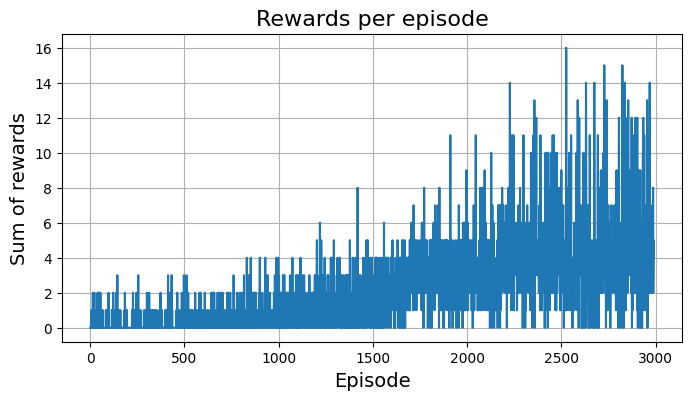

In [15]:
# Plot rewards per episode
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Rewards per episode", fontsize=16)
plt.grid(True)
plt.show()

The moving average plot for this agent shows steady, stable improvement over the course of 2992 episodes. There is little oscillation prior to episode 1500. Afterwards, there is some slight variation but the trend improves fairly consistently.

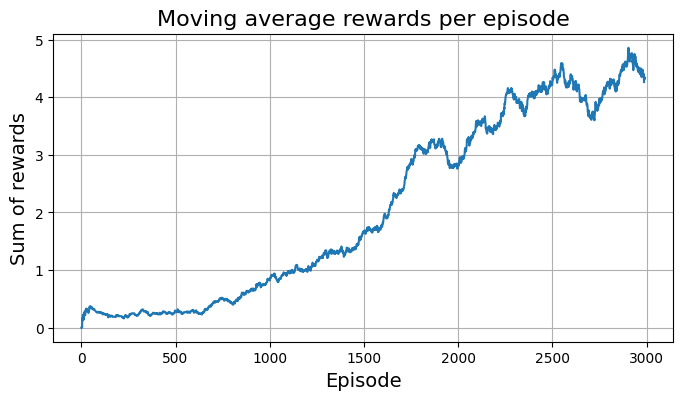

In [16]:
# Plot moving average rewards per episode
plt.figure(figsize=(8, 4))
plt.plot(moving_average_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Moving average rewards per episode", fontsize=16)
plt.grid(True)
plt.show()

As with the previous agents, the steps taken per episode closely reflects the rewards per episode. The maximum number of steps taken is approximately 500. These longer episodes are responsible for the increase in execution time as training progresses. This posed a challenge when it came to estimating how long it will take to run a given number of episodes.

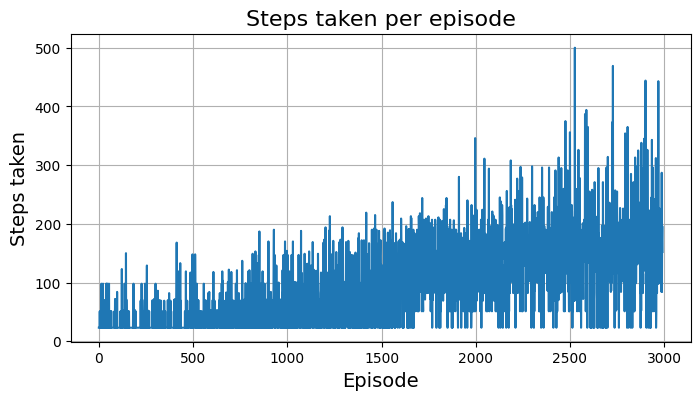

In [17]:
# Plot steps taken per episode
plt.figure(figsize=(8, 4))
plt.plot(steps_taken)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Steps taken", fontsize=14)
plt.title("Steps taken per episode", fontsize=16)
plt.grid(True)
plt.show()

The following animation shows the agent playing an episode. Compared to the previous two animations, this looks a lot better. While the paddle movement is still a bit choppy, it looks reasonable and achieves a respectable score of 4. The ball is lost at a small margin as well, which is not too bad.

In [18]:
# Display an animation of one episode
show_one_episode(epsilon_greedy_policy)

In [ ]:
# Adam optimizer improves training time
optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-4, clipnorm=1.0)

# He initialisation
initializer = tf.keras.initializers.VarianceScaling

loss_fn = tf.keras.losses.Huber()

In [ ]:
# Ensures reproducibility on the CPU
tf.random.set_seed(42)

input_shape = env.observation_space.shape
n_outputs = env.action_space.n

model = tf.keras.Sequential([
    # Preprocessing
    tf.keras.layers.Permute((2, 3, 1), input_shape=input_shape),
    tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.),

    # Convolutional layers
    tf.keras.layers.Conv2D(32, (8, 8), 4, activation="relu",
                           kernel_initializer=initializer(scale=2)),
    tf.keras.layers.Conv2D(64, (4, 4), 2, activation="relu",
                           kernel_initializer=initializer(scale=2)),
    tf.keras.layers.Conv2D(64, (3, 3), 1, activation="relu",
                           kernel_initializer=initializer(scale=2)),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu",
                          kernel_initializer=initializer(scale=2)),
    tf.keras.layers.Dense(n_outputs, activation="linear")
])

# Clone the model's architecture
target = tf.keras.models.clone_model(model)

# Copy the weights
target.set_weights(model.get_weights())

# For reproducibility
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
replay_buffer = PrioritisedExperienceReplayBuffer(max_size=max_memory_length,
                                                  alpha=0.6, beta=0.7)

rewards = []
moving_average_rewards = []
steps_taken = []

epsilon = 1.0
frame_count = 0
best_score = 0

episode_iterator = tqdm(range(max_episodes))
for episode in episode_iterator:
    obs, info = env.reset()
    episode_reward = 0

    for step in range(max_steps_per_episode):
        obs, reward, done, truncated, info = play_one_step_per(env, obs,
                                                               epsilon)

        # Decay probability of taking random action
        epsilon -= (1 - 0.1) / 100000
        epsilon = max(epsilon, 0.1)

        # Run training step every 4 frames
        if (frame_count % update_after_actions == 0
            and len(replay_buffer) > batch_size):
            training_step_double_dqn_per(batch_size)

        # Update target network every 1000 frames
        if frame_count % update_target_network == 0:
            target.set_weights(model.get_weights())

        episode_reward += reward
        frame_count += 1

        if done or truncated:
            break

    # Record rewards
    rewards.append(episode_reward)

    # Record moving average reward
    moving_average_rewards.append(np.mean(rewards[-100:]))

    # Record steps taken
    steps_taken.append(step)

    tqdm.write(f"\repisode: {episode + 1}, steps: {step + 1}, " \
               f"frame count: {frame_count}, epsilon: {epsilon:.3f}, " \
               f"episode reward: {episode_reward}, " \
               f"moving average reward: {moving_average_rewards[-1]:.3f}",
               end='')

    # Keeps track of the best model weights so far
    if episode_reward >= best_score:
        best_weights = model.get_weights()
        best_score = episode_reward

# Restores the best model weights
model.set_weights(best_weights)

  0%|          | 0/5000 [00:00<?, ?it/s]

episode: 4964, steps: 52, frame count: 672380, epsilon: 0.100, episode reward: 1.0, moving average reward: 6.890

In a subsequent attempt at running this code, the improved Double DQN agent was able to achieve a moving average reward of 6.890 over 672,380 frames. This happended before being terminated at 4964/5000 episodes (over 17 hours wall-clock time) due to being disconnected from the remote runtime at 99% completion (not an issue with the code itself). Devestatingly, it was not possible to restore any of the state information, so the model weights and episode history were lost, so no plots or visualisations could be produced.

However, other than teaching me a valuable lesson about using checkpoints to save my work in the future, this incomplete run demonstrates that this agent continues to improve beyond what is shown in the previous results. Anecdotally, I did notice the moving average reward fluctuate both above and below 6.890 while observing the training progress, but I don't recall the moving average going any lower than the previous result of 4.340.

Another point of note is that this second run just barely exceeds the human benchmark of 6.36 points per life, meaning that this model is able to match the performance of an average professional human game tester. While this is still very far from the 80.2 achieved by the DeepMind agent per life, I would say that it is a fairly respectable result within the scope of this project. 

## c. Discussions in Published Papers or Blogs that Provide Additional Insight

To provide some insight and context into the results of from the different implementations presented in this project, we can compare them with what others have been able to achieve on the same task.

I have already mentioned the DQN from the DeepMind paper several times, which achieved a score of 401.2 in 2015 [5]. They went on to improve on this score 418.5 in a different paper in 2016 using a Double DQN [14]. There were several major RL advancements for Breakout later that year, the most significant being another DeepMind paper on Bootstrapped DQN, which achieved a score of 855.0 on the game [15]. The most recent RL improvement in the game was in 2022, where researchers used Generalised Data Distribution Iteration (GDI), to attain the maximum possible score of 864 [16].

There are also various blogs published online of developers sharing their experiences training an RL agent for Breakout. 

One Medium article reports running 1,000,000 steps for a maximum score of 24, 3,000,000 steps for a maximum score of 62, and 5,000,000 steps for a maximum score of 63. Throughout this training process, the author notes that he did not observe the agent discovering an advanced strategy, despite this being suggested in literature [17].

Another online article mentions receiving an average reward close to 20 after training for 20,000 episodes. The learning curve shown indicates that they reached an average reward of 6 after about 14,000 episodes [18].

The main takeaway from this is that I likely would have been able to get better results had I let the models run for a longer duration using the hyperparameters as described in literature. All things considered, an average score of 6.890 for one life is a fairly decent result after processing only 4964 episodes (672,380 frames). 

However, a huge limitation in this project was not having easy access to reliable compute resources that allowed me to easily run and debug my code without a high possibility of it being interupted. In hindsight, I could have been more proactive in setting my code up in such a way that constantly writes data to the drive during training. 

Something else I've noticed is that my model runs very slowly compared to what other people have reported. Even on state-of-the-art hardware, my training processes were comparatively slow. This suggests that there is a lot of room for optimisation in my code, since I suspect that there may be significant portions of code that do not run effectively in parallel. Improvements in this regard would lead to far more efficient training processes in the future.

# 9. References

1. I. Szita, ‘Reinforcement Learning in Games’, in Reinforcement Learning: State-of-the-Art, M. Wiering and M. van Otterlo, Eds., Berlin, Heidelberg: Springer, 2012, pp. 539–577. doi: 10.1007/978-3-642-27645-3_17.

2. ‘ALE Documentation’. Accessed: May 13, 2025. [Online]. Available: https://ale.farama.org/index.html

3. V. Mnih et al., ‘Playing Atari with Deep Reinforcement Learning’, Dec. 19, 2013, arXiv: arXiv:1312.5602. doi: 10.48550/arXiv.1312.5602.

4. ‘AtariAge - Atari 2600 Manuals (HTML) - Breakout (Atari)’. Accessed: May 12, 2025. [Online]. Available: https://atariage.com/manual_html_page.php?SoftwareID=889

5. V. Mnih et al., ‘Human-level control through deep reinforcement learning’, Nature, vol. 518, no. 7540, pp. 529–533, Feb. 2015, doi: 10.1038/nature14236.

6. A. Géron, Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems, Second edition. Beijing [China] ; Sebastopol, CA: O’Reilly Media, Inc, 2019.

7. H. van Hasselt, A. Guez, and D. Silver, ‘Deep Reinforcement Learning with Double Q-learning’, Dec. 08, 2015, arXiv: arXiv:1509.06461. doi: 10.48550/arXiv.1509.06461.

8. Z. Huang, J. Ou, and M. Wang, ‘Comparison and analysis of DQN performance with different hyperparameters’, ACE, vol. 15, no. 1, pp. 22–29, Oct. 2023, doi: 10.54254/2755-2721/15/20230806.

9. W. Fedus et al., ‘Revisiting Fundamentals of Experience Replay’, Jul. 13, 2020, arXiv: arXiv:2007.06700. doi: 10.48550/arXiv.2007.06700.

10. M. Hessel et al., ‘Rainbow: Combining Improvements in Deep Reinforcement Learning’, Oct. 06, 2017, arXiv: arXiv:1710.02298. doi: 10.48550/arXiv.1710.02298.

11. K. Team, ‘Keras documentation: Deep Q-Learning for Atari Breakout’. Accessed: May 14, 2025. [Online]. Available: https://keras.io/examples/rl/deep_q_network_breakout/

12. K. He, X. Zhang, S. Ren, and J. Sun, ‘Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification’, Feb. 06, 2015, arXiv: arXiv:1502.01852. doi: 10.48550/arXiv.1502.01852.

13. T. Schaul, J. Quan, I. Antonoglou, and D. Silver, ‘Prioritized Experience Replay’, Feb. 25, 2016, arXiv: arXiv:1511.05952. doi: 10.48550/arXiv.1511.05952.

14. Z. Wang, T. Schaul, M. Hessel, H. van Hasselt, M. Lanctot, and N. de Freitas, ‘Dueling Network Architectures for Deep Reinforcement Learning’, Apr. 05, 2016, arXiv: arXiv:1511.06581. doi: 10.48550/arXiv.1511.06581.

15. I. Osband, C. Blundell, A. Pritzel, and B. V. Roy, ‘Deep Exploration via Bootstrapped DQN’, Jul. 04, 2016, arXiv: arXiv:1602.04621. doi: 10.48550/arXiv.1602.04621.

16. J. Fan and C. Xiao, ‘Generalized Data Distribution Iteration’, Jun. 20, 2022, arXiv: arXiv:2206.03192. doi: 10.48550/arXiv.2206.03192.

17. Boen, ‘Atari Breakout Master’, Medium. Accessed: May 14, 2025. [Online]. Available: https://medium.com/@bwzhi/atari-breakout-master-8d2cf22495f5

18. ‘Playing Atari Breakout - DQN using Pytorch - Shree Blogs’. Accessed: May 14, 2025. [Online]. Available: https://shreeshan.github.io/2019/10/26/rl_dqn.html